In [1]:
import pandas as pd
from tabnet.classifier import TabNetClassifier
from tabnet.autoencoder import TabNetAutoencoder
import tabnet_utils
from sklearn.model_selection import train_test_split
from datetime import datetime
import tensorflow
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score

In [3]:
df = pd.read_csv('/home/karim/Research/DSAA2022/symptom/Training.csv')
data = df.sample(frac=1).reset_index(drop=True)

In [4]:
data.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,Hepatitis D
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Varicose veins
2,0,1,0,0,0,0,1,0,0,0,...,0,0,1,1,1,1,0,0,0,Psoriasis
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Chicken pox
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Hypoglycemia


In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['prognosis'] = le.fit_transform(data['prognosis'])

In [6]:
data.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,21
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,39
2,0,1,0,0,0,0,1,0,0,0,...,0,0,1,1,1,1,0,0,0,35
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,25


In [7]:
_, types = tabnet_utils.convert_data_types(data) 
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:-1], data.iloc[:,-1])
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [8]:
X_train.shape, X_valid.shape, X_test.shape

((2952, 132), (738, 132), (1230, 132))

In [9]:
len(y_train.unique())

41

In [10]:
columns = [tabnet_utils.get_feature(f, types[k]) for k, f in X_train.iteritems()] 

In [12]:
y_train = tensorflow.keras.utils.to_categorical(y_train, 41)
y_valid = tensorflow.keras.utils.to_categorical(y_valid, 41)
y_test = tensorflow.keras.utils.to_categorical(y_test, 41)

In [13]:
train, valid, test = tabnet_utils.df_to_dataset(X_train, y_train), tabnet_utils.df_to_dataset(X_valid, y_valid), tabnet_utils.df_to_dataset(X_test, y_test) 

2022-05-20 09:34:50.624203: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-20 09:34:52.929252: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 276 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:17:00.0, compute capability: 7.5
2022-05-20 09:34:52.930123: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22501 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:73:00.0, compute capability: 7.5
2022-05-20 09:34:52.930824: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU

In [16]:
 m = TabNetClassifier(feature_columns=columns, num_features=132, num_outputs=41, feature_dim=32, output_dim=16, num_decision_steps=2, relaxation_factor=1.2, 
                                  sparsity_coefficient=0.0001, batch_momentum=0.9, classifier_activation=tensorflow.keras.activations.softmax)

logdir = "/home/karim/Research/DSAA2022/logs/" + "/" + datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir=logdir)

m.compile(tensorflow.keras.optimizers.Adam(0.01), loss=tensorflow.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
m.fit(train, epochs=10, validation_data=valid)

m.summary()

Epoch 1/10


ValueError: in user code:

    File "/home/karim/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/home/karim/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/karim/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/home/karim/.local/lib/python3.8/site-packages/keras/engine/training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "/home/karim/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "tab_net_classifier_2" (type TabNetClassifier).
    
    in user code:
    
        File "/home/karim/Research/DSAA2022/tabnet/classifier.py", line 108, in call  *
            prediction, _, _, _ = self.encoder(inputs, training=True)
        File "/home/karim/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
    
        ValueError: Exception encountered when calling layer "tab_net_encoder_2" (type TabNetEncoder).
        
        in user code:
        
            File "/home/karim/Research/DSAA2022/tabnet/encoder.py", line 162, in call  *
                features = self.input_features(inputs)
            File "/home/karim/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
                raise e.with_traceback(filtered_tb) from None
            File "/usr/lib/python3.8/contextlib.py", line 113, in __enter__
                return next(self.gen)
        
            ValueError: Exception encountered when calling layer "dense_features_2" (type DenseFeatures).
            
            'dischromic _patches' is not a valid scope name. A scope name has to match the following pattern: ^[A-Za-z0-9_.\\/>-]*$
            
            Call arguments received:
              • features={'itching': 'tf.Tensor(shape=(None,), dtype=int64)', 'skin_rash': 'tf.Tensor(shape=(None,), dtype=int64)', 'nodal_skin_eruptions': 'tf.Tensor(shape=(None,), dtype=int64)', 'continuous_sneezing': 'tf.Tensor(shape=(None,), dtype=int64)', 'shivering': 'tf.Tensor(shape=(None,), dtype=int64)', 'chills': 'tf.Tensor(shape=(None,), dtype=int64)', 'joint_pain': 'tf.Tensor(shape=(None,), dtype=int64)', 'stomach_pain': 'tf.Tensor(shape=(None,), dtype=int64)', 'acidity': 'tf.Tensor(shape=(None,), dtype=int64)', 'ulcers_on_tongue': 'tf.Tensor(shape=(None,), dtype=int64)', 'muscle_wasting': 'tf.Tensor(shape=(None,), dtype=int64)', 'vomiting': 'tf.Tensor(shape=(None,), dtype=int64)', 'burning_micturition': 'tf.Tensor(shape=(None,), dtype=int64)', 'spotting_ urination': 'tf.Tensor(shape=(None,), dtype=int64)', 'fatigue': 'tf.Tensor(shape=(None,), dtype=int64)', 'weight_gain': 'tf.Tensor(shape=(None,), dtype=int64)', 'anxiety': 'tf.Tensor(shape=(None,), dtype=int64)', 'cold_hands_and_feets': 'tf.Tensor(shape=(None,), dtype=int64)', 'mood_swings': 'tf.Tensor(shape=(None,), dtype=int64)', 'weight_loss': 'tf.Tensor(shape=(None,), dtype=int64)', 'restlessness': 'tf.Tensor(shape=(None,), dtype=int64)', 'lethargy': 'tf.Tensor(shape=(None,), dtype=int64)', 'patches_in_throat': 'tf.Tensor(shape=(None,), dtype=int64)', 'irregular_sugar_level': 'tf.Tensor(shape=(None,), dtype=int64)', 'cough': 'tf.Tensor(shape=(None,), dtype=int64)', 'high_fever': 'tf.Tensor(shape=(None,), dtype=int64)', 'sunken_eyes': 'tf.Tensor(shape=(None,), dtype=int64)', 'breathlessness': 'tf.Tensor(shape=(None,), dtype=int64)', 'sweating': 'tf.Tensor(shape=(None,), dtype=int64)', 'dehydration': 'tf.Tensor(shape=(None,), dtype=int64)', 'indigestion': 'tf.Tensor(shape=(None,), dtype=int64)', 'headache': 'tf.Tensor(shape=(None,), dtype=int64)', 'yellowish_skin': 'tf.Tensor(shape=(None,), dtype=int64)', 'dark_urine': 'tf.Tensor(shape=(None,), dtype=int64)', 'nausea': 'tf.Tensor(shape=(None,), dtype=int64)', 'loss_of_appetite': 'tf.Tensor(shape=(None,), dtype=int64)', 'pain_behind_the_eyes': 'tf.Tensor(shape=(None,), dtype=int64)', 'back_pain': 'tf.Tensor(shape=(None,), dtype=int64)', 'constipation': 'tf.Tensor(shape=(None,), dtype=int64)', 'abdominal_pain': 'tf.Tensor(shape=(None,), dtype=int64)', 'diarrhoea': 'tf.Tensor(shape=(None,), dtype=int64)', 'mild_fever': 'tf.Tensor(shape=(None,), dtype=int64)', 'yellow_urine': 'tf.Tensor(shape=(None,), dtype=int64)', 'yellowing_of_eyes': 'tf.Tensor(shape=(None,), dtype=int64)', 'acute_liver_failure': 'tf.Tensor(shape=(None,), dtype=int64)', 'fluid_overload': 'tf.Tensor(shape=(None,), dtype=int64)', 'swelling_of_stomach': 'tf.Tensor(shape=(None,), dtype=int64)', 'swelled_lymph_nodes': 'tf.Tensor(shape=(None,), dtype=int64)', 'malaise': 'tf.Tensor(shape=(None,), dtype=int64)', 'blurred_and_distorted_vision': 'tf.Tensor(shape=(None,), dtype=int64)', 'phlegm': 'tf.Tensor(shape=(None,), dtype=int64)', 'throat_irritation': 'tf.Tensor(shape=(None,), dtype=int64)', 'redness_of_eyes': 'tf.Tensor(shape=(None,), dtype=int64)', 'sinus_pressure': 'tf.Tensor(shape=(None,), dtype=int64)', 'runny_nose': 'tf.Tensor(shape=(None,), dtype=int64)', 'congestion': 'tf.Tensor(shape=(None,), dtype=int64)', 'chest_pain': 'tf.Tensor(shape=(None,), dtype=int64)', 'weakness_in_limbs': 'tf.Tensor(shape=(None,), dtype=int64)', 'fast_heart_rate': 'tf.Tensor(shape=(None,), dtype=int64)', 'pain_during_bowel_movements': 'tf.Tensor(shape=(None,), dtype=int64)', 'pain_in_anal_region': 'tf.Tensor(shape=(None,), dtype=int64)', 'bloody_stool': 'tf.Tensor(shape=(None,), dtype=int64)', 'irritation_in_anus': 'tf.Tensor(shape=(None,), dtype=int64)', 'neck_pain': 'tf.Tensor(shape=(None,), dtype=int64)', 'dizziness': 'tf.Tensor(shape=(None,), dtype=int64)', 'cramps': 'tf.Tensor(shape=(None,), dtype=int64)', 'bruising': 'tf.Tensor(shape=(None,), dtype=int64)', 'obesity': 'tf.Tensor(shape=(None,), dtype=int64)', 'swollen_legs': 'tf.Tensor(shape=(None,), dtype=int64)', 'swollen_blood_vessels': 'tf.Tensor(shape=(None,), dtype=int64)', 'puffy_face_and_eyes': 'tf.Tensor(shape=(None,), dtype=int64)', 'enlarged_thyroid': 'tf.Tensor(shape=(None,), dtype=int64)', 'brittle_nails': 'tf.Tensor(shape=(None,), dtype=int64)', 'swollen_extremeties': 'tf.Tensor(shape=(None,), dtype=int64)', 'excessive_hunger': 'tf.Tensor(shape=(None,), dtype=int64)', 'extra_marital_contacts': 'tf.Tensor(shape=(None,), dtype=int64)', 'drying_and_tingling_lips': 'tf.Tensor(shape=(None,), dtype=int64)', 'slurred_speech': 'tf.Tensor(shape=(None,), dtype=int64)', 'knee_pain': 'tf.Tensor(shape=(None,), dtype=int64)', 'hip_joint_pain': 'tf.Tensor(shape=(None,), dtype=int64)', 'muscle_weakness': 'tf.Tensor(shape=(None,), dtype=int64)', 'stiff_neck': 'tf.Tensor(shape=(None,), dtype=int64)', 'swelling_joints': 'tf.Tensor(shape=(None,), dtype=int64)', 'movement_stiffness': 'tf.Tensor(shape=(None,), dtype=int64)', 'spinning_movements': 'tf.Tensor(shape=(None,), dtype=int64)', 'loss_of_balance': 'tf.Tensor(shape=(None,), dtype=int64)', 'unsteadiness': 'tf.Tensor(shape=(None,), dtype=int64)', 'weakness_of_one_body_side': 'tf.Tensor(shape=(None,), dtype=int64)', 'loss_of_smell': 'tf.Tensor(shape=(None,), dtype=int64)', 'bladder_discomfort': 'tf.Tensor(shape=(None,), dtype=int64)', 'foul_smell_of urine': 'tf.Tensor(shape=(None,), dtype=int64)', 'continuous_feel_of_urine': 'tf.Tensor(shape=(None,), dtype=int64)', 'passage_of_gases': 'tf.Tensor(shape=(None,), dtype=int64)', 'internal_itching': 'tf.Tensor(shape=(None,), dtype=int64)', 'toxic_look_(typhos)': 'tf.Tensor(shape=(None,), dtype=int64)', 'depression': 'tf.Tensor(shape=(None,), dtype=int64)', 'irritability': 'tf.Tensor(shape=(None,), dtype=int64)', 'muscle_pain': 'tf.Tensor(shape=(None,), dtype=int64)', 'altered_sensorium': 'tf.Tensor(shape=(None,), dtype=int64)', 'red_spots_over_body': 'tf.Tensor(shape=(None,), dtype=int64)', 'belly_pain': 'tf.Tensor(shape=(None,), dtype=int64)', 'abnormal_menstruation': 'tf.Tensor(shape=(None,), dtype=int64)', 'dischromic _patches': 'tf.Tensor(shape=(None,), dtype=int64)', 'watering_from_eyes': 'tf.Tensor(shape=(None,), dtype=int64)', 'increased_appetite': 'tf.Tensor(shape=(None,), dtype=int64)', 'polyuria': 'tf.Tensor(shape=(None,), dtype=int64)', 'family_history': 'tf.Tensor(shape=(None,), dtype=int64)', 'mucoid_sputum': 'tf.Tensor(shape=(None,), dtype=int64)', 'rusty_sputum': 'tf.Tensor(shape=(None,), dtype=int64)', 'lack_of_concentration': 'tf.Tensor(shape=(None,), dtype=int64)', 'visual_disturbances': 'tf.Tensor(shape=(None,), dtype=int64)', 'receiving_blood_transfusion': 'tf.Tensor(shape=(None,), dtype=int64)', 'receiving_unsterile_injections': 'tf.Tensor(shape=(None,), dtype=int64)', 'coma': 'tf.Tensor(shape=(None,), dtype=int64)', 'stomach_bleeding': 'tf.Tensor(shape=(None,), dtype=int64)', 'distention_of_abdomen': 'tf.Tensor(shape=(None,), dtype=int64)', 'history_of_alcohol_consumption': 'tf.Tensor(shape=(None,), dtype=int64)', 'fluid_overload.1': 'tf.Tensor(shape=(None,), dtype=int64)', 'blood_in_sputum': 'tf.Tensor(shape=(None,), dtype=int64)', 'prominent_veins_on_calf': 'tf.Tensor(shape=(None,), dtype=int64)', 'palpitations': 'tf.Tensor(shape=(None,), dtype=int64)', 'painful_walking': 'tf.Tensor(shape=(None,), dtype=int64)', 'pus_filled_pimples': 'tf.Tensor(shape=(None,), dtype=int64)', 'blackheads': 'tf.Tensor(shape=(None,), dtype=int64)', 'scurring': 'tf.Tensor(shape=(None,), dtype=int64)', 'skin_peeling': 'tf.Tensor(shape=(None,), dtype=int64)', 'silver_like_dusting': 'tf.Tensor(shape=(None,), dtype=int64)', 'small_dents_in_nails': 'tf.Tensor(shape=(None,), dtype=int64)', 'inflammatory_nails': 'tf.Tensor(shape=(None,), dtype=int64)', 'blister': 'tf.Tensor(shape=(None,), dtype=int64)', 'red_sore_around_nose': 'tf.Tensor(shape=(None,), dtype=int64)', 'yellow_crust_ooze': 'tf.Tensor(shape=(None,), dtype=int64)'}
              • cols_to_output_tensors=None
              • training=True
        
        
        Call arguments received:
          • inputs={'itching': 'tf.Tensor(shape=(None,), dtype=int64)', 'skin_rash': 'tf.Tensor(shape=(None,), dtype=int64)', 'nodal_skin_eruptions': 'tf.Tensor(shape=(None,), dtype=int64)', 'continuous_sneezing': 'tf.Tensor(shape=(None,), dtype=int64)', 'shivering': 'tf.Tensor(shape=(None,), dtype=int64)', 'chills': 'tf.Tensor(shape=(None,), dtype=int64)', 'joint_pain': 'tf.Tensor(shape=(None,), dtype=int64)', 'stomach_pain': 'tf.Tensor(shape=(None,), dtype=int64)', 'acidity': 'tf.Tensor(shape=(None,), dtype=int64)', 'ulcers_on_tongue': 'tf.Tensor(shape=(None,), dtype=int64)', 'muscle_wasting': 'tf.Tensor(shape=(None,), dtype=int64)', 'vomiting': 'tf.Tensor(shape=(None,), dtype=int64)', 'burning_micturition': 'tf.Tensor(shape=(None,), dtype=int64)', 'spotting_ urination': 'tf.Tensor(shape=(None,), dtype=int64)', 'fatigue': 'tf.Tensor(shape=(None,), dtype=int64)', 'weight_gain': 'tf.Tensor(shape=(None,), dtype=int64)', 'anxiety': 'tf.Tensor(shape=(None,), dtype=int64)', 'cold_hands_and_feets': 'tf.Tensor(shape=(None,), dtype=int64)', 'mood_swings': 'tf.Tensor(shape=(None,), dtype=int64)', 'weight_loss': 'tf.Tensor(shape=(None,), dtype=int64)', 'restlessness': 'tf.Tensor(shape=(None,), dtype=int64)', 'lethargy': 'tf.Tensor(shape=(None,), dtype=int64)', 'patches_in_throat': 'tf.Tensor(shape=(None,), dtype=int64)', 'irregular_sugar_level': 'tf.Tensor(shape=(None,), dtype=int64)', 'cough': 'tf.Tensor(shape=(None,), dtype=int64)', 'high_fever': 'tf.Tensor(shape=(None,), dtype=int64)', 'sunken_eyes': 'tf.Tensor(shape=(None,), dtype=int64)', 'breathlessness': 'tf.Tensor(shape=(None,), dtype=int64)', 'sweating': 'tf.Tensor(shape=(None,), dtype=int64)', 'dehydration': 'tf.Tensor(shape=(None,), dtype=int64)', 'indigestion': 'tf.Tensor(shape=(None,), dtype=int64)', 'headache': 'tf.Tensor(shape=(None,), dtype=int64)', 'yellowish_skin': 'tf.Tensor(shape=(None,), dtype=int64)', 'dark_urine': 'tf.Tensor(shape=(None,), dtype=int64)', 'nausea': 'tf.Tensor(shape=(None,), dtype=int64)', 'loss_of_appetite': 'tf.Tensor(shape=(None,), dtype=int64)', 'pain_behind_the_eyes': 'tf.Tensor(shape=(None,), dtype=int64)', 'back_pain': 'tf.Tensor(shape=(None,), dtype=int64)', 'constipation': 'tf.Tensor(shape=(None,), dtype=int64)', 'abdominal_pain': 'tf.Tensor(shape=(None,), dtype=int64)', 'diarrhoea': 'tf.Tensor(shape=(None,), dtype=int64)', 'mild_fever': 'tf.Tensor(shape=(None,), dtype=int64)', 'yellow_urine': 'tf.Tensor(shape=(None,), dtype=int64)', 'yellowing_of_eyes': 'tf.Tensor(shape=(None,), dtype=int64)', 'acute_liver_failure': 'tf.Tensor(shape=(None,), dtype=int64)', 'fluid_overload': 'tf.Tensor(shape=(None,), dtype=int64)', 'swelling_of_stomach': 'tf.Tensor(shape=(None,), dtype=int64)', 'swelled_lymph_nodes': 'tf.Tensor(shape=(None,), dtype=int64)', 'malaise': 'tf.Tensor(shape=(None,), dtype=int64)', 'blurred_and_distorted_vision': 'tf.Tensor(shape=(None,), dtype=int64)', 'phlegm': 'tf.Tensor(shape=(None,), dtype=int64)', 'throat_irritation': 'tf.Tensor(shape=(None,), dtype=int64)', 'redness_of_eyes': 'tf.Tensor(shape=(None,), dtype=int64)', 'sinus_pressure': 'tf.Tensor(shape=(None,), dtype=int64)', 'runny_nose': 'tf.Tensor(shape=(None,), dtype=int64)', 'congestion': 'tf.Tensor(shape=(None,), dtype=int64)', 'chest_pain': 'tf.Tensor(shape=(None,), dtype=int64)', 'weakness_in_limbs': 'tf.Tensor(shape=(None,), dtype=int64)', 'fast_heart_rate': 'tf.Tensor(shape=(None,), dtype=int64)', 'pain_during_bowel_movements': 'tf.Tensor(shape=(None,), dtype=int64)', 'pain_in_anal_region': 'tf.Tensor(shape=(None,), dtype=int64)', 'bloody_stool': 'tf.Tensor(shape=(None,), dtype=int64)', 'irritation_in_anus': 'tf.Tensor(shape=(None,), dtype=int64)', 'neck_pain': 'tf.Tensor(shape=(None,), dtype=int64)', 'dizziness': 'tf.Tensor(shape=(None,), dtype=int64)', 'cramps': 'tf.Tensor(shape=(None,), dtype=int64)', 'bruising': 'tf.Tensor(shape=(None,), dtype=int64)', 'obesity': 'tf.Tensor(shape=(None,), dtype=int64)', 'swollen_legs': 'tf.Tensor(shape=(None,), dtype=int64)', 'swollen_blood_vessels': 'tf.Tensor(shape=(None,), dtype=int64)', 'puffy_face_and_eyes': 'tf.Tensor(shape=(None,), dtype=int64)', 'enlarged_thyroid': 'tf.Tensor(shape=(None,), dtype=int64)', 'brittle_nails': 'tf.Tensor(shape=(None,), dtype=int64)', 'swollen_extremeties': 'tf.Tensor(shape=(None,), dtype=int64)', 'excessive_hunger': 'tf.Tensor(shape=(None,), dtype=int64)', 'extra_marital_contacts': 'tf.Tensor(shape=(None,), dtype=int64)', 'drying_and_tingling_lips': 'tf.Tensor(shape=(None,), dtype=int64)', 'slurred_speech': 'tf.Tensor(shape=(None,), dtype=int64)', 'knee_pain': 'tf.Tensor(shape=(None,), dtype=int64)', 'hip_joint_pain': 'tf.Tensor(shape=(None,), dtype=int64)', 'muscle_weakness': 'tf.Tensor(shape=(None,), dtype=int64)', 'stiff_neck': 'tf.Tensor(shape=(None,), dtype=int64)', 'swelling_joints': 'tf.Tensor(shape=(None,), dtype=int64)', 'movement_stiffness': 'tf.Tensor(shape=(None,), dtype=int64)', 'spinning_movements': 'tf.Tensor(shape=(None,), dtype=int64)', 'loss_of_balance': 'tf.Tensor(shape=(None,), dtype=int64)', 'unsteadiness': 'tf.Tensor(shape=(None,), dtype=int64)', 'weakness_of_one_body_side': 'tf.Tensor(shape=(None,), dtype=int64)', 'loss_of_smell': 'tf.Tensor(shape=(None,), dtype=int64)', 'bladder_discomfort': 'tf.Tensor(shape=(None,), dtype=int64)', 'foul_smell_of urine': 'tf.Tensor(shape=(None,), dtype=int64)', 'continuous_feel_of_urine': 'tf.Tensor(shape=(None,), dtype=int64)', 'passage_of_gases': 'tf.Tensor(shape=(None,), dtype=int64)', 'internal_itching': 'tf.Tensor(shape=(None,), dtype=int64)', 'toxic_look_(typhos)': 'tf.Tensor(shape=(None,), dtype=int64)', 'depression': 'tf.Tensor(shape=(None,), dtype=int64)', 'irritability': 'tf.Tensor(shape=(None,), dtype=int64)', 'muscle_pain': 'tf.Tensor(shape=(None,), dtype=int64)', 'altered_sensorium': 'tf.Tensor(shape=(None,), dtype=int64)', 'red_spots_over_body': 'tf.Tensor(shape=(None,), dtype=int64)', 'belly_pain': 'tf.Tensor(shape=(None,), dtype=int64)', 'abnormal_menstruation': 'tf.Tensor(shape=(None,), dtype=int64)', 'dischromic _patches': 'tf.Tensor(shape=(None,), dtype=int64)', 'watering_from_eyes': 'tf.Tensor(shape=(None,), dtype=int64)', 'increased_appetite': 'tf.Tensor(shape=(None,), dtype=int64)', 'polyuria': 'tf.Tensor(shape=(None,), dtype=int64)', 'family_history': 'tf.Tensor(shape=(None,), dtype=int64)', 'mucoid_sputum': 'tf.Tensor(shape=(None,), dtype=int64)', 'rusty_sputum': 'tf.Tensor(shape=(None,), dtype=int64)', 'lack_of_concentration': 'tf.Tensor(shape=(None,), dtype=int64)', 'visual_disturbances': 'tf.Tensor(shape=(None,), dtype=int64)', 'receiving_blood_transfusion': 'tf.Tensor(shape=(None,), dtype=int64)', 'receiving_unsterile_injections': 'tf.Tensor(shape=(None,), dtype=int64)', 'coma': 'tf.Tensor(shape=(None,), dtype=int64)', 'stomach_bleeding': 'tf.Tensor(shape=(None,), dtype=int64)', 'distention_of_abdomen': 'tf.Tensor(shape=(None,), dtype=int64)', 'history_of_alcohol_consumption': 'tf.Tensor(shape=(None,), dtype=int64)', 'fluid_overload.1': 'tf.Tensor(shape=(None,), dtype=int64)', 'blood_in_sputum': 'tf.Tensor(shape=(None,), dtype=int64)', 'prominent_veins_on_calf': 'tf.Tensor(shape=(None,), dtype=int64)', 'palpitations': 'tf.Tensor(shape=(None,), dtype=int64)', 'painful_walking': 'tf.Tensor(shape=(None,), dtype=int64)', 'pus_filled_pimples': 'tf.Tensor(shape=(None,), dtype=int64)', 'blackheads': 'tf.Tensor(shape=(None,), dtype=int64)', 'scurring': 'tf.Tensor(shape=(None,), dtype=int64)', 'skin_peeling': 'tf.Tensor(shape=(None,), dtype=int64)', 'silver_like_dusting': 'tf.Tensor(shape=(None,), dtype=int64)', 'small_dents_in_nails': 'tf.Tensor(shape=(None,), dtype=int64)', 'inflammatory_nails': 'tf.Tensor(shape=(None,), dtype=int64)', 'blister': 'tf.Tensor(shape=(None,), dtype=int64)', 'red_sore_around_nose': 'tf.Tensor(shape=(None,), dtype=int64)', 'yellow_crust_ooze': 'tf.Tensor(shape=(None,), dtype=int64)'}
          • priors_initialization=None
          • training=True
    
    
    Call arguments received:
      • inputs={'itching': 'tf.Tensor(shape=(None,), dtype=int64)', 'skin_rash': 'tf.Tensor(shape=(None,), dtype=int64)', 'nodal_skin_eruptions': 'tf.Tensor(shape=(None,), dtype=int64)', 'continuous_sneezing': 'tf.Tensor(shape=(None,), dtype=int64)', 'shivering': 'tf.Tensor(shape=(None,), dtype=int64)', 'chills': 'tf.Tensor(shape=(None,), dtype=int64)', 'joint_pain': 'tf.Tensor(shape=(None,), dtype=int64)', 'stomach_pain': 'tf.Tensor(shape=(None,), dtype=int64)', 'acidity': 'tf.Tensor(shape=(None,), dtype=int64)', 'ulcers_on_tongue': 'tf.Tensor(shape=(None,), dtype=int64)', 'muscle_wasting': 'tf.Tensor(shape=(None,), dtype=int64)', 'vomiting': 'tf.Tensor(shape=(None,), dtype=int64)', 'burning_micturition': 'tf.Tensor(shape=(None,), dtype=int64)', 'spotting_ urination': 'tf.Tensor(shape=(None,), dtype=int64)', 'fatigue': 'tf.Tensor(shape=(None,), dtype=int64)', 'weight_gain': 'tf.Tensor(shape=(None,), dtype=int64)', 'anxiety': 'tf.Tensor(shape=(None,), dtype=int64)', 'cold_hands_and_feets': 'tf.Tensor(shape=(None,), dtype=int64)', 'mood_swings': 'tf.Tensor(shape=(None,), dtype=int64)', 'weight_loss': 'tf.Tensor(shape=(None,), dtype=int64)', 'restlessness': 'tf.Tensor(shape=(None,), dtype=int64)', 'lethargy': 'tf.Tensor(shape=(None,), dtype=int64)', 'patches_in_throat': 'tf.Tensor(shape=(None,), dtype=int64)', 'irregular_sugar_level': 'tf.Tensor(shape=(None,), dtype=int64)', 'cough': 'tf.Tensor(shape=(None,), dtype=int64)', 'high_fever': 'tf.Tensor(shape=(None,), dtype=int64)', 'sunken_eyes': 'tf.Tensor(shape=(None,), dtype=int64)', 'breathlessness': 'tf.Tensor(shape=(None,), dtype=int64)', 'sweating': 'tf.Tensor(shape=(None,), dtype=int64)', 'dehydration': 'tf.Tensor(shape=(None,), dtype=int64)', 'indigestion': 'tf.Tensor(shape=(None,), dtype=int64)', 'headache': 'tf.Tensor(shape=(None,), dtype=int64)', 'yellowish_skin': 'tf.Tensor(shape=(None,), dtype=int64)', 'dark_urine': 'tf.Tensor(shape=(None,), dtype=int64)', 'nausea': 'tf.Tensor(shape=(None,), dtype=int64)', 'loss_of_appetite': 'tf.Tensor(shape=(None,), dtype=int64)', 'pain_behind_the_eyes': 'tf.Tensor(shape=(None,), dtype=int64)', 'back_pain': 'tf.Tensor(shape=(None,), dtype=int64)', 'constipation': 'tf.Tensor(shape=(None,), dtype=int64)', 'abdominal_pain': 'tf.Tensor(shape=(None,), dtype=int64)', 'diarrhoea': 'tf.Tensor(shape=(None,), dtype=int64)', 'mild_fever': 'tf.Tensor(shape=(None,), dtype=int64)', 'yellow_urine': 'tf.Tensor(shape=(None,), dtype=int64)', 'yellowing_of_eyes': 'tf.Tensor(shape=(None,), dtype=int64)', 'acute_liver_failure': 'tf.Tensor(shape=(None,), dtype=int64)', 'fluid_overload': 'tf.Tensor(shape=(None,), dtype=int64)', 'swelling_of_stomach': 'tf.Tensor(shape=(None,), dtype=int64)', 'swelled_lymph_nodes': 'tf.Tensor(shape=(None,), dtype=int64)', 'malaise': 'tf.Tensor(shape=(None,), dtype=int64)', 'blurred_and_distorted_vision': 'tf.Tensor(shape=(None,), dtype=int64)', 'phlegm': 'tf.Tensor(shape=(None,), dtype=int64)', 'throat_irritation': 'tf.Tensor(shape=(None,), dtype=int64)', 'redness_of_eyes': 'tf.Tensor(shape=(None,), dtype=int64)', 'sinus_pressure': 'tf.Tensor(shape=(None,), dtype=int64)', 'runny_nose': 'tf.Tensor(shape=(None,), dtype=int64)', 'congestion': 'tf.Tensor(shape=(None,), dtype=int64)', 'chest_pain': 'tf.Tensor(shape=(None,), dtype=int64)', 'weakness_in_limbs': 'tf.Tensor(shape=(None,), dtype=int64)', 'fast_heart_rate': 'tf.Tensor(shape=(None,), dtype=int64)', 'pain_during_bowel_movements': 'tf.Tensor(shape=(None,), dtype=int64)', 'pain_in_anal_region': 'tf.Tensor(shape=(None,), dtype=int64)', 'bloody_stool': 'tf.Tensor(shape=(None,), dtype=int64)', 'irritation_in_anus': 'tf.Tensor(shape=(None,), dtype=int64)', 'neck_pain': 'tf.Tensor(shape=(None,), dtype=int64)', 'dizziness': 'tf.Tensor(shape=(None,), dtype=int64)', 'cramps': 'tf.Tensor(shape=(None,), dtype=int64)', 'bruising': 'tf.Tensor(shape=(None,), dtype=int64)', 'obesity': 'tf.Tensor(shape=(None,), dtype=int64)', 'swollen_legs': 'tf.Tensor(shape=(None,), dtype=int64)', 'swollen_blood_vessels': 'tf.Tensor(shape=(None,), dtype=int64)', 'puffy_face_and_eyes': 'tf.Tensor(shape=(None,), dtype=int64)', 'enlarged_thyroid': 'tf.Tensor(shape=(None,), dtype=int64)', 'brittle_nails': 'tf.Tensor(shape=(None,), dtype=int64)', 'swollen_extremeties': 'tf.Tensor(shape=(None,), dtype=int64)', 'excessive_hunger': 'tf.Tensor(shape=(None,), dtype=int64)', 'extra_marital_contacts': 'tf.Tensor(shape=(None,), dtype=int64)', 'drying_and_tingling_lips': 'tf.Tensor(shape=(None,), dtype=int64)', 'slurred_speech': 'tf.Tensor(shape=(None,), dtype=int64)', 'knee_pain': 'tf.Tensor(shape=(None,), dtype=int64)', 'hip_joint_pain': 'tf.Tensor(shape=(None,), dtype=int64)', 'muscle_weakness': 'tf.Tensor(shape=(None,), dtype=int64)', 'stiff_neck': 'tf.Tensor(shape=(None,), dtype=int64)', 'swelling_joints': 'tf.Tensor(shape=(None,), dtype=int64)', 'movement_stiffness': 'tf.Tensor(shape=(None,), dtype=int64)', 'spinning_movements': 'tf.Tensor(shape=(None,), dtype=int64)', 'loss_of_balance': 'tf.Tensor(shape=(None,), dtype=int64)', 'unsteadiness': 'tf.Tensor(shape=(None,), dtype=int64)', 'weakness_of_one_body_side': 'tf.Tensor(shape=(None,), dtype=int64)', 'loss_of_smell': 'tf.Tensor(shape=(None,), dtype=int64)', 'bladder_discomfort': 'tf.Tensor(shape=(None,), dtype=int64)', 'foul_smell_of urine': 'tf.Tensor(shape=(None,), dtype=int64)', 'continuous_feel_of_urine': 'tf.Tensor(shape=(None,), dtype=int64)', 'passage_of_gases': 'tf.Tensor(shape=(None,), dtype=int64)', 'internal_itching': 'tf.Tensor(shape=(None,), dtype=int64)', 'toxic_look_(typhos)': 'tf.Tensor(shape=(None,), dtype=int64)', 'depression': 'tf.Tensor(shape=(None,), dtype=int64)', 'irritability': 'tf.Tensor(shape=(None,), dtype=int64)', 'muscle_pain': 'tf.Tensor(shape=(None,), dtype=int64)', 'altered_sensorium': 'tf.Tensor(shape=(None,), dtype=int64)', 'red_spots_over_body': 'tf.Tensor(shape=(None,), dtype=int64)', 'belly_pain': 'tf.Tensor(shape=(None,), dtype=int64)', 'abnormal_menstruation': 'tf.Tensor(shape=(None,), dtype=int64)', 'dischromic _patches': 'tf.Tensor(shape=(None,), dtype=int64)', 'watering_from_eyes': 'tf.Tensor(shape=(None,), dtype=int64)', 'increased_appetite': 'tf.Tensor(shape=(None,), dtype=int64)', 'polyuria': 'tf.Tensor(shape=(None,), dtype=int64)', 'family_history': 'tf.Tensor(shape=(None,), dtype=int64)', 'mucoid_sputum': 'tf.Tensor(shape=(None,), dtype=int64)', 'rusty_sputum': 'tf.Tensor(shape=(None,), dtype=int64)', 'lack_of_concentration': 'tf.Tensor(shape=(None,), dtype=int64)', 'visual_disturbances': 'tf.Tensor(shape=(None,), dtype=int64)', 'receiving_blood_transfusion': 'tf.Tensor(shape=(None,), dtype=int64)', 'receiving_unsterile_injections': 'tf.Tensor(shape=(None,), dtype=int64)', 'coma': 'tf.Tensor(shape=(None,), dtype=int64)', 'stomach_bleeding': 'tf.Tensor(shape=(None,), dtype=int64)', 'distention_of_abdomen': 'tf.Tensor(shape=(None,), dtype=int64)', 'history_of_alcohol_consumption': 'tf.Tensor(shape=(None,), dtype=int64)', 'fluid_overload.1': 'tf.Tensor(shape=(None,), dtype=int64)', 'blood_in_sputum': 'tf.Tensor(shape=(None,), dtype=int64)', 'prominent_veins_on_calf': 'tf.Tensor(shape=(None,), dtype=int64)', 'palpitations': 'tf.Tensor(shape=(None,), dtype=int64)', 'painful_walking': 'tf.Tensor(shape=(None,), dtype=int64)', 'pus_filled_pimples': 'tf.Tensor(shape=(None,), dtype=int64)', 'blackheads': 'tf.Tensor(shape=(None,), dtype=int64)', 'scurring': 'tf.Tensor(shape=(None,), dtype=int64)', 'skin_peeling': 'tf.Tensor(shape=(None,), dtype=int64)', 'silver_like_dusting': 'tf.Tensor(shape=(None,), dtype=int64)', 'small_dents_in_nails': 'tf.Tensor(shape=(None,), dtype=int64)', 'inflammatory_nails': 'tf.Tensor(shape=(None,), dtype=int64)', 'blister': 'tf.Tensor(shape=(None,), dtype=int64)', 'red_sore_around_nose': 'tf.Tensor(shape=(None,), dtype=int64)', 'yellow_crust_ooze': 'tf.Tensor(shape=(None,), dtype=int64)'}


In [12]:
y_pred = m.predict(test).round()

In [13]:
y_test_argmax = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

In [14]:
from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(y_test_argmax, y_pred, average='weighted'))

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
confusion_matrix = confusion_matrix(y_test_argmax, y_pred)
print(confusion_matrix)

print(classification_report(y_test_argmax, y_pred))

/home/karim/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.8939470121158023, 0.8848836168616139, 0.8889563145284527, None)
[[    0     0     0     0     0     0     0     0]
 [  167 46536  5683     0     0    49    11   447]
 [  418  4177 65326   236     8   379   271    29]
 [  379     0   344  7322    81     1   788     0]
 [   52     0     0   155   433     0    35     0]
 [  154    49   721    49     0  1367    10     0]
 [  452    17   358   622    27     0  2917     0]
 [   15   469    68     0     0     0     0  4631]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.91      0.88      0.89     52893
           2       0.90      0.92      0.91     70844
           3       0.87      0.82      0.85      8915
           4       0.79      0.64      0.71       675
           5       0.76      0.58      0.66      2350
           6       0.72      0.66      0.69      4393
           7       0.91      0.89      0.90      5183

    accuracy                        

<AxesSubplot:title={'center':'Global feature importance'}>

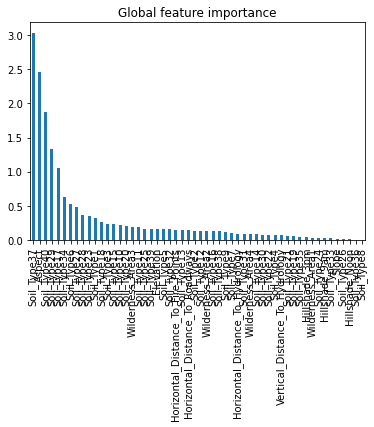

In [16]:
global_test = m.explain(dict(X_test)).numpy()
indices_test = global_test.mean(0).argsort()[::-1]
pd.Series(global_test.mean(0)[indices_test], index=X_test.columns[indices_test]).plot.bar(title='Global feature importance')